# Firebase Analytics For MapSwipe

Helpful resources: 

* https://support.google.com/firebase/answer/7029846?hl=en&ref_topic=7029512
* https://firebase.google.com/docs/analytics/screenviews
* https://support.google.com/firebase/answer/6317485
* https://firebase.google.com/docs/ab-testing/abtest-with-console

What are the most common events? 

```
SELECT
  event_name,
  COUNT(*)
FROM
  `msf-mapswipe.analytics_153173126.events_*`
GROUP BY
  1
ORDER BY
  2 DESC
```

What is `session_start`? Could we use this to help us out with sessions? 

> session_start - An Analytics event that counts user sessions in your app. To learn more, see Automatically collected events. 


This is an interesting query: 

```
SELECT
  user_pseudo_id,
  MIN(TIMESTAMP_MICROS( user_first_touch_timestamp ))
FROM
  `msf-mapswipe.analytics_153173126.events_2018*`
GROUP BY
  1
ORDER BY
  2 ASC
```

Within the new analytics table, it gives the minimum first touch per user (basically, we get a count of total users in the timeframe as well as when they started using the application). The minimum value ends up being 2016-07-15 which is when MapSwipe was first released.


When we look at this query: 

```
SELECT
  TIMESTAMP_MICROS(event_timestamp),
  event_name,
  user_pseudo_id
FROM
  `msf-mapswipe.analytics_153173126.events_20180713`
WHERE
  event_name = 'mapswipe_open'
  OR event_name = 'session_start'
ORDER BY
  1
```

We note that more often than not, the `mapswipe_open` event (logged by the app) and the `session_start` events roughly coincide. The session start seems to happen about 10 seconds after the logged opening of the app, which seems to correspond with the [minimum session duration](https://firebase.google.com/docs/reference/android/com/google/firebase/analytics/FirebaseAnalytics#setMinimumSessionDuration(long)) threshold default parameter.


What is the average session length? Median? 

When do people start sessions, by weekday? 

It seems that Thursday is the most popular day to MapSwipe.

In the older versions of analytics, the field `user_dim.app_info.app_instance_id` acts as the `user_pseudo_id`. 

This [article](https://statsbot.co/blog/event-analytics-define-user-sessions-sql/) gives a good overview of how to turn raw events into something that looks like a session. 

# Plotting By Weekday

We can use the query: 


``` sql
SELECT
  FORMAT_TIMESTAMP('%A', session_start_at) AS weekday,
  duration_minutes
FROM (
  SELECT
    session_id,
    session_start_at,
    TIMESTAMP_DIFF(MAX(TIMESTAMP_MICROS(events.event_timestamp)), MIN(TIMESTAMP_MICROS(events.event_timestamp)), SECOND) / 60 AS duration_minutes
  FROM
    `analytics_153173126.mapswipe_sessions` AS sessions
  LEFT JOIN
    `analytics_153173126.events_2*` AS events
  ON
    events.user_pseudo_id = sessions.user_pseudo_id
    AND TIMESTAMP_MICROS(events.event_timestamp) > sessions.session_start_at
    AND (TIMESTAMP_MICROS(events.event_timestamp) < sessions.next_session_start_at
      OR sessions.next_session_start_at IS NULL)
  GROUP BY
    1, 2 )
    
    GROUP BY 1, 2
    ORDER BY 2 ASC
```

to retreive the raw data for this. 

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
df = pd.read_csv('~/Downloads/results-20180717-205247.csv')

In [8]:
df.isnull().sum()

weekday               0
duration_minutes    347
dtype: int64

Any time the duration is null, it means there was no subsequent session (and thus the number of minutes in duration is 0).

In [11]:
df.fillna(0, inplace=True)

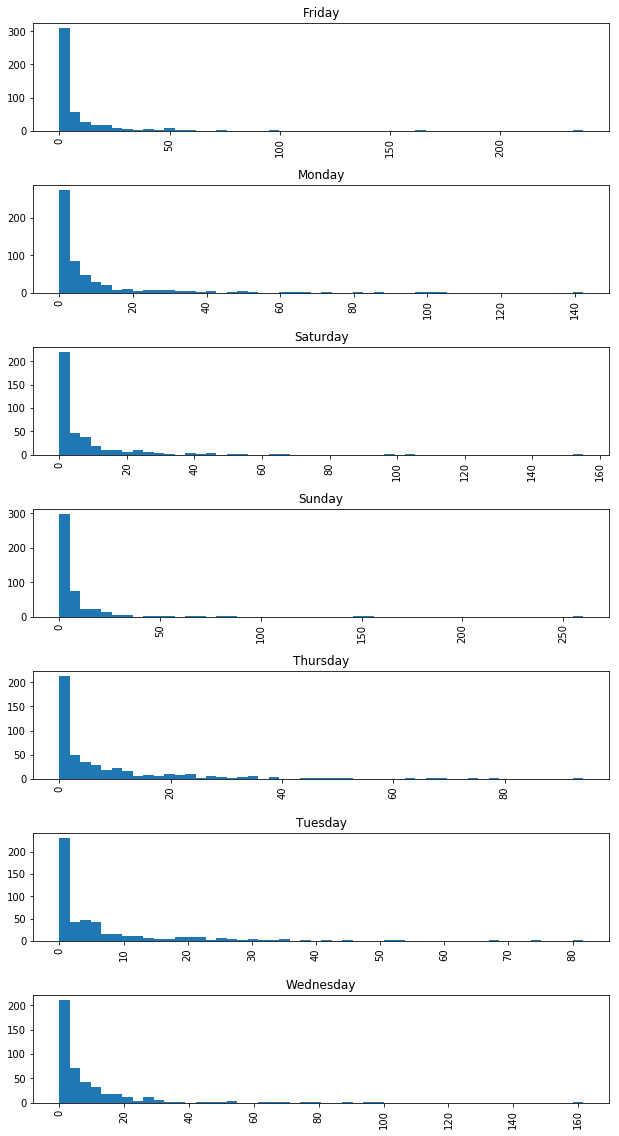

In [14]:
df['duration_minutes'].hist(by=df['weekday'], bins=50, figsize=(10, 20), layout=(7,1))
plt.savefig('session_duration_histogram_by_weekday.png')